In [48]:
## import openml
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import time

from models.plot_func import *

## Section 1: Reading the data

In [49]:
# X, y, _, _ = openml.datasets.get_dataset(42750).get_data(dataset_format="dataframe")
# df = X.copy()
df = pd.read_csv('Census-Income-KDD.csv')
print(df.shape)

(199523, 42)


In [50]:
df.columns

Index(['age', 'class_worker', 'det_ind_code', 'det_occ_code', 'education',
       'wage_per_hour', 'hs_college', 'marital_stat', 'major_ind_code',
       'major_occ_code', 'race', 'hisp_origin', 'sex', 'union_member',
       'unemp_reason', 'full_or_part_emp', 'capital_gains', 'capital_losses',
       'stock_dividends', 'tax_filer_stat', 'region_prev_res',
       'state_prev_res', 'det_hh_fam_stat', 'det_hh_summ', 'unknown',
       'mig_chg_msa', 'mig_chg_reg', 'mig_move_reg', 'mig_same',
       'mig_prev_sunbelt', 'num_emp', 'fam_under_18', 'country_father',
       'country_mother', 'country_self', 'citizenship', 'own_or_self',
       'vet_question', 'vet_benefits', 'weeks_worked', 'year', 'income_50k'],
      dtype='object')

we drop the "unknown" column since it should not be used for classsifiers (from the dataset description).

In [51]:
df = df.drop('unknown', axis=1)

in our case, the target variable is "income_50k" and the rest of the variables are the features.

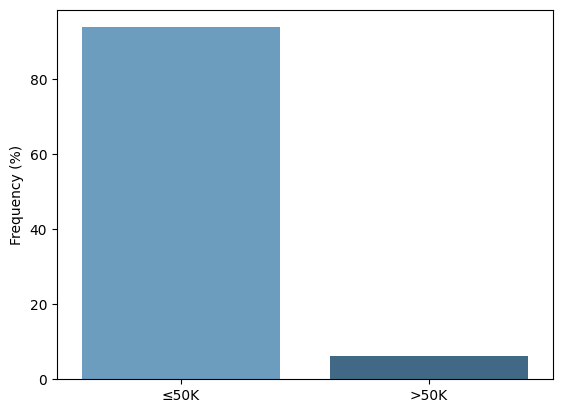

In [52]:
sns.barplot(x=df['income_50k'].value_counts(normalize=True).index, y=df['income_50k'].value_counts(normalize=True)*100, palette='Blues_d')
plt.xticks([0,1], ['≤50K', '>50K'])
plt.ylabel('Frequency (%)')
plt.savefig('figures/target_freq.pdf', bbox_inches='tight')
plt.show()

## Section 2: Basic inspection of the data

In [53]:
df.describe()

,age,det_ind_code,det_occ_code,wage_per_hour,capital_gains,capital_losses,stock_dividends,num_emp,own_or_self,vet_benefits,weeks_worked,year
count,199523.000000,199523.000000,199523.000000,199523.000000,199523.00000,199523.000000,199523.000000,199523.000000,199523.000000,199523.000000,199523.000000,199523.000000
mean,34.494199,15.352320,11.306556,55.426908,434.71899,37.313788,197.529533,1.956180,0.175438,1.514833,23.174897,94.499672
std,22.310895,18.067129,14.454204,274.896454,4697.53128,271.896428,1984.163658,2.365126,0.553694,0.851473,24.411488,0.500001
min,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,94.000000
25%,15.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,94.000000
50%,33.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,1.000000,0.000000,2.000000,8.000000,94.000000
75%,50.000000,33.000000,26.000000,0.000000,0.00000,0.000000,0.000000,4.000000,0.000000,2.000000,52.000000,95.000000
max,90.000000,51.000000,46.000000,9999.000000,99999.00000,4608.000000,99999.000000,6.000000,2.000000,2.000000,52.000000,95.000000


In [54]:
# count column types
df.dtypes.value_counts()

object    29
int64     12
dtype: int64

<Axes: >

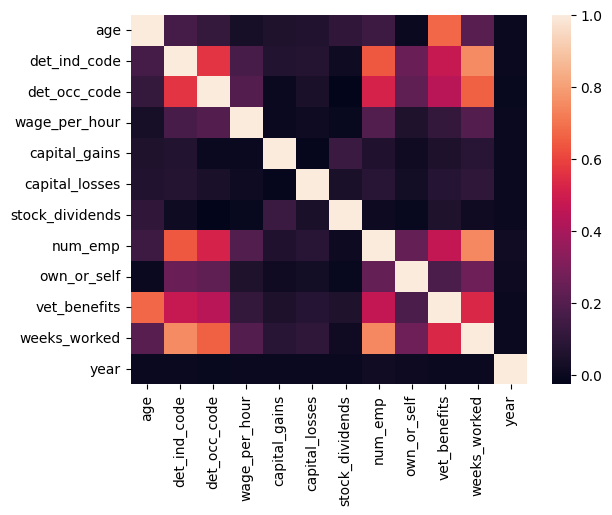

In [55]:
# heatmap of the correlation between the numerical features
corr = df.select_dtypes(include=['int64', 'float64']).corr()
sns.heatmap(corr,
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)

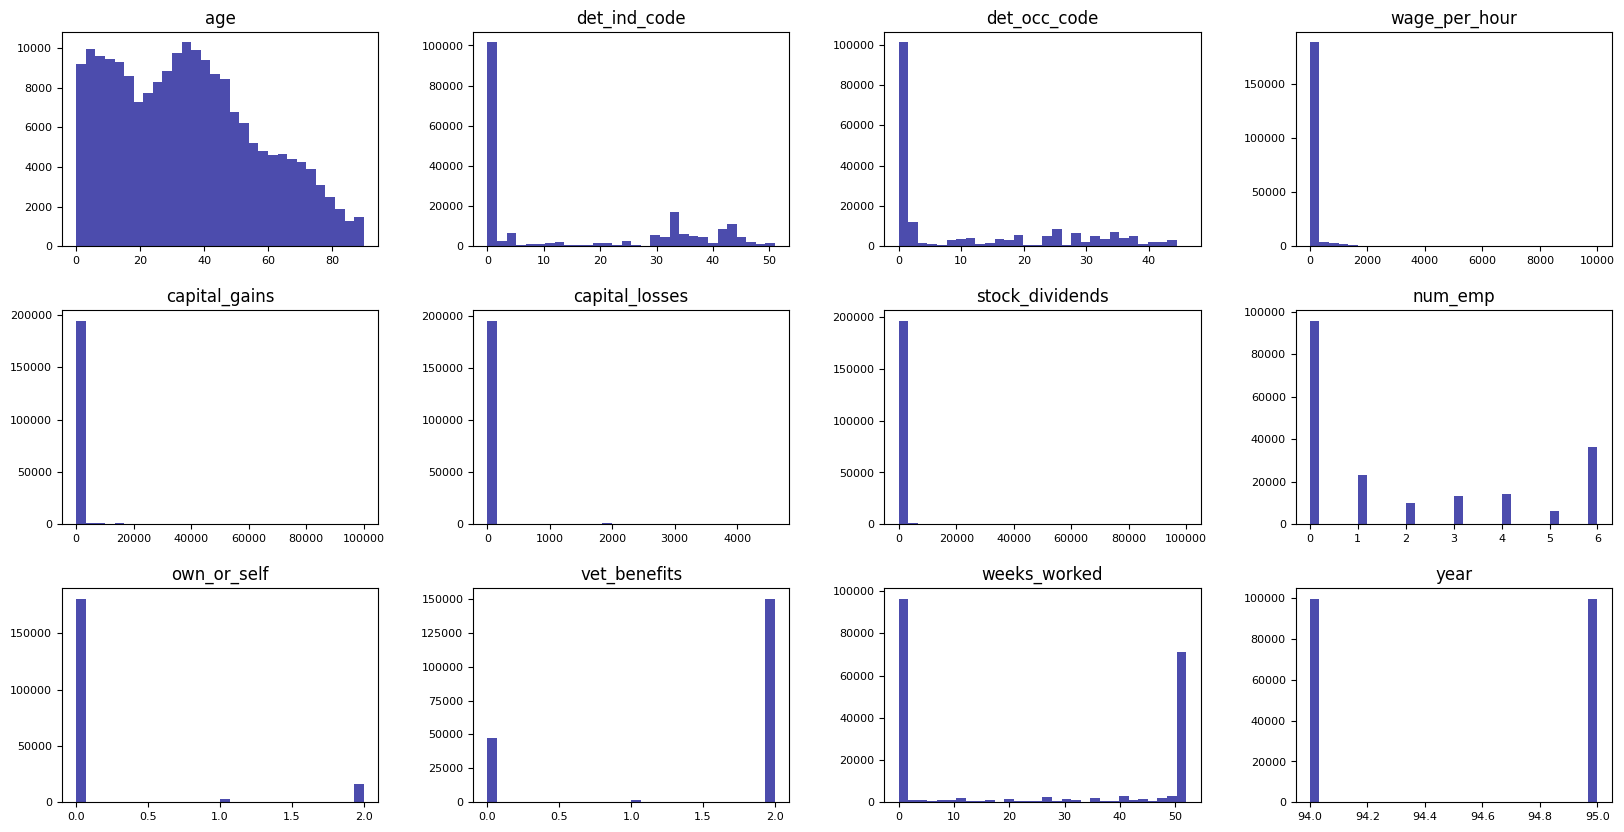

In [56]:
df.hist(figsize=(20,10), bins=30, xlabelsize=8, ylabelsize=8, layout=(3,4), color='darkblue', alpha=0.7, grid=False)
plt.savefig('figures/all_num_histograms.pdf', bbox_inches='tight')
plt.show()

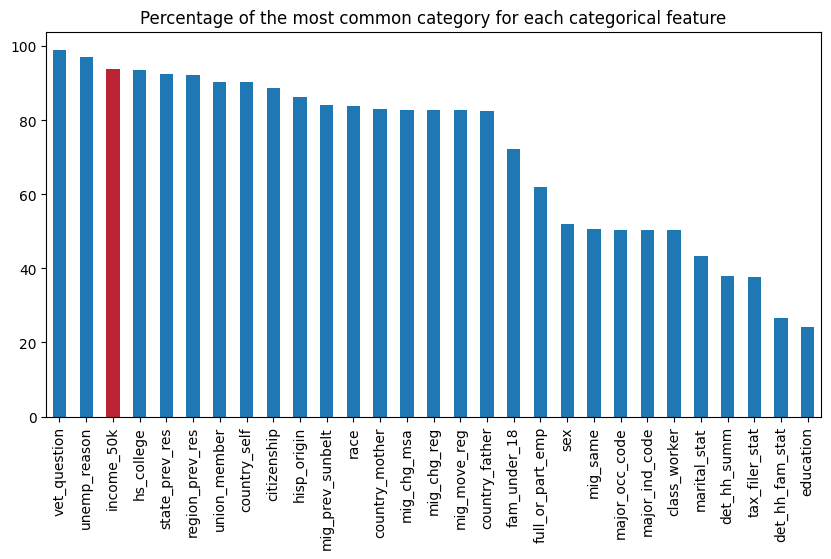

In [57]:
a = df.select_dtypes(include=['object']).apply(lambda x: x.value_counts(normalize=True).max()*100)
a = a.sort_values(ascending=False)
a.plot(kind='bar', figsize=(10,5))
plt.bar(a.index.get_loc('income_50k'), a['income_50k'], color='red', width=0.5, label='income_50k', alpha=0.7)
plt.title('Percentage of the most common category for each categorical feature')
plt.savefig('figures/raw_cat_most_common.pdf', bbox_inches='tight')
plt.show()

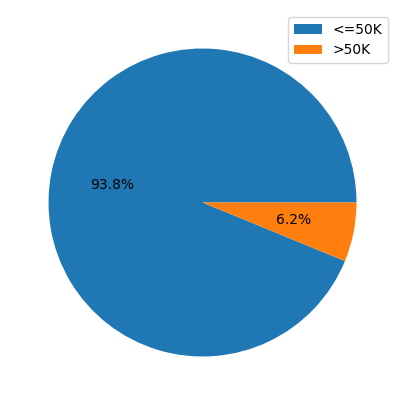

In [58]:
# pieplot of income_50k, change the names of - 50000. and 50000+. to <=50K and >50K
df['income_50k'].value_counts().plot(kind='pie', autopct='%1.1f%%', figsize=(5,5), labels=['', ''])
plt.legend(labels=['<=50K', '>50K'])
plt.ylabel('')
plt.savefig('figures/target_freq.pdf')
plt.show()

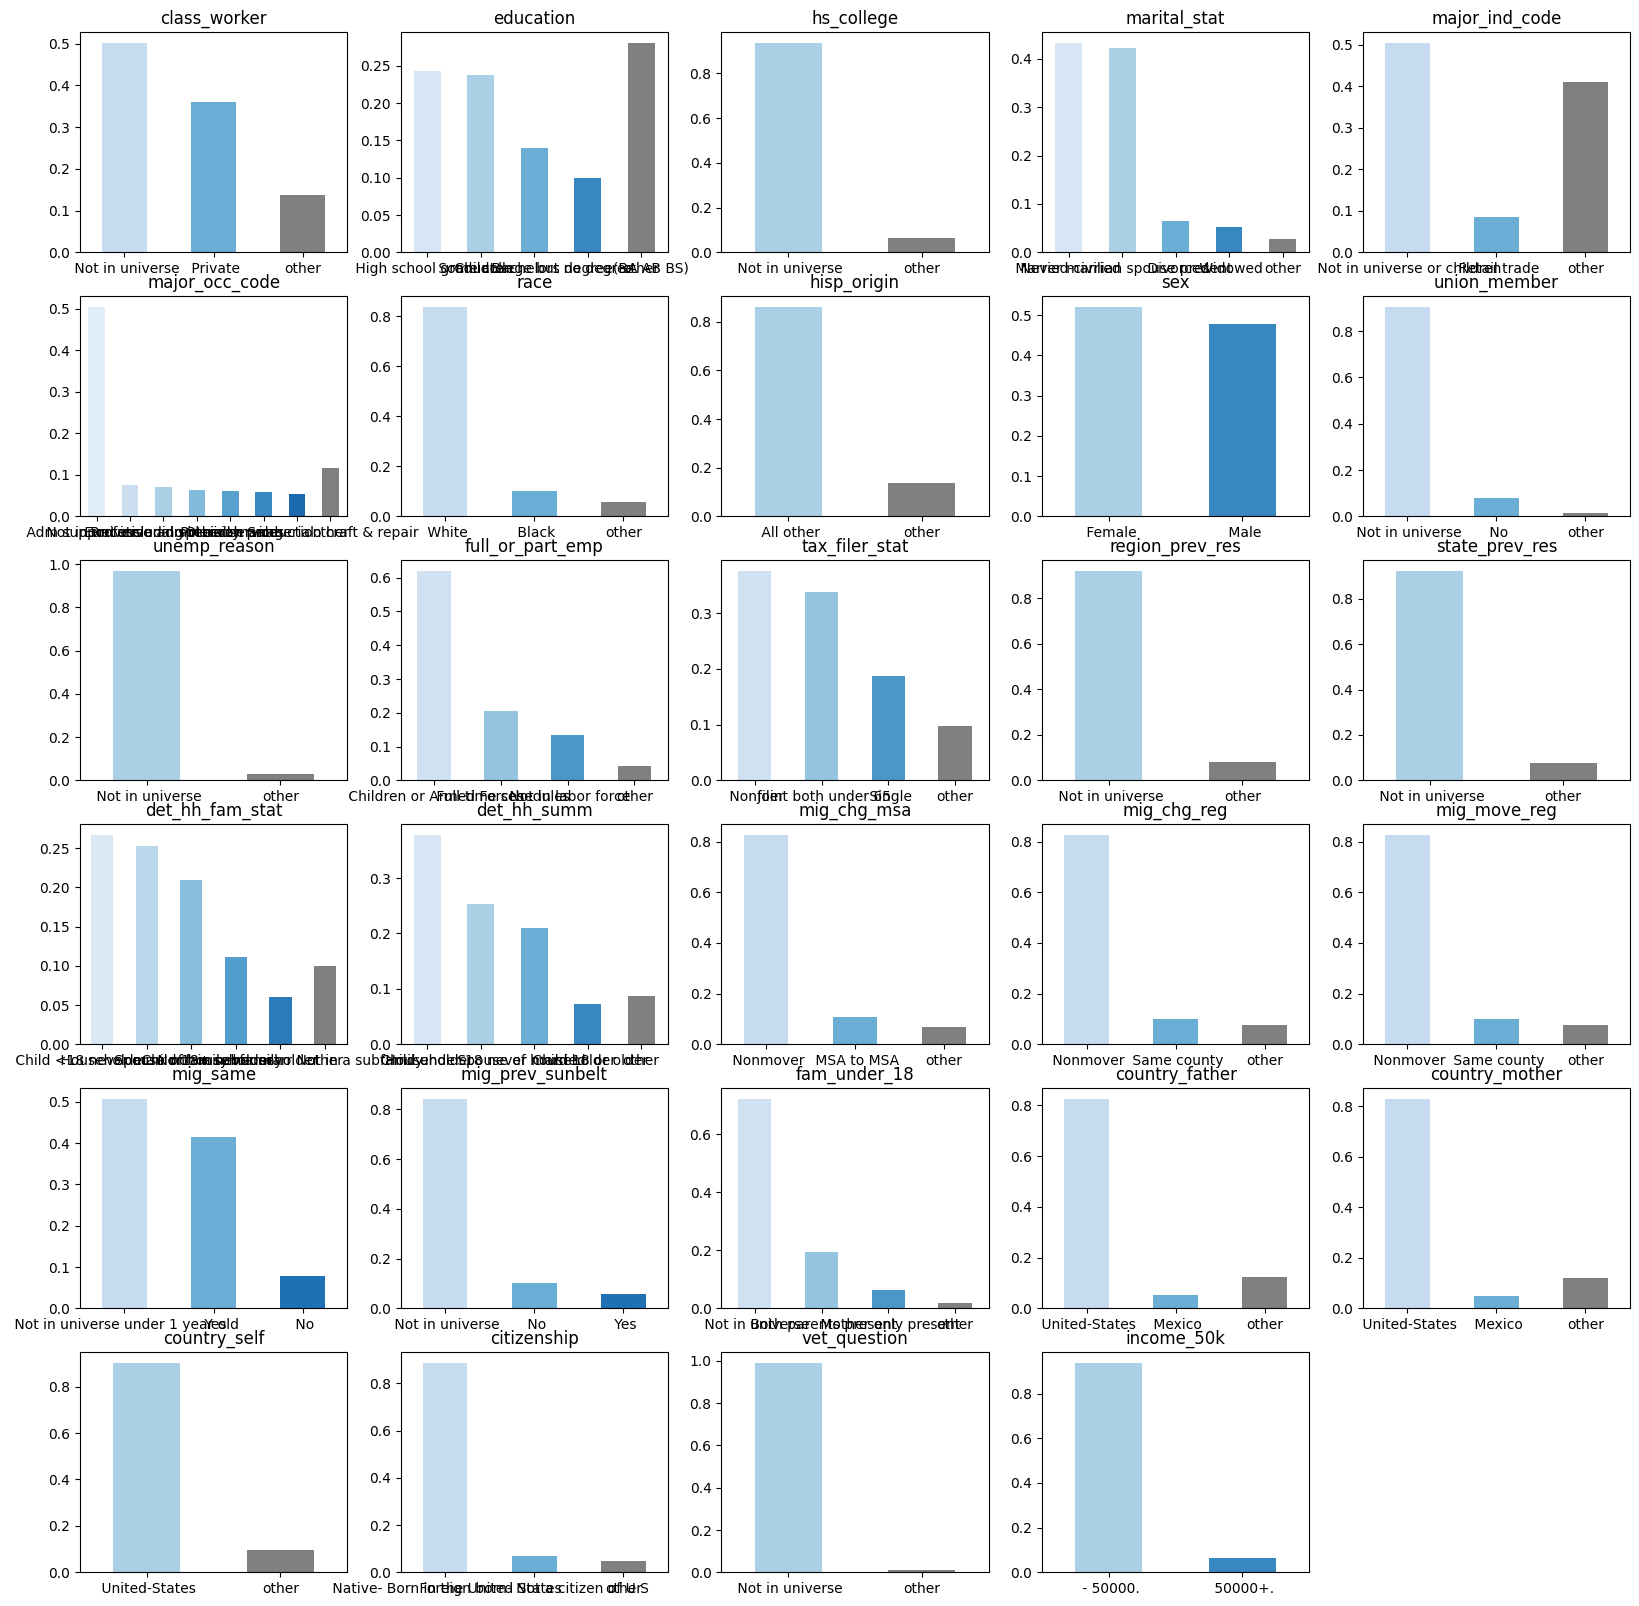

In [59]:
cat_col = df.select_dtypes(include=['object']).columns
barplots(df, cat_col, figsize=(20, 20))

## Section 3: Data cleaning

In [60]:
df1 = df.copy()

To avoid having correlation between the rows, we drop the duplicates.

In [61]:
# show the number of duplicates
print(f"Number of duplicates: {df1.duplicated().sum()}")
df1 = df1.drop_duplicates()
print(f"Number of rows after removing duplicates: {df1.shape[0]}")

Number of duplicates: 46627
Number of rows after removing duplicates: 152896


### Missing values detection

In [62]:
df1.describe()

,age,det_ind_code,det_occ_code,wage_per_hour,capital_gains,capital_losses,stock_dividends,num_emp,own_or_self,vet_benefits,weeks_worked,year
count,152896.000000,152896.000000,152896.000000,152896.000000,152896.000000,152896.000000,152896.000000,152896.000000,152896.000000,152896.000000,152896.000000,152896.000000
mean,39.719371,19.942922,14.672876,72.324279,567.237115,48.664471,257.019255,2.538052,0.228587,1.821061,30.061591,94.490163
std,19.662074,18.234760,14.887964,312.072448,5359.204656,309.511387,2261.405280,2.403920,0.622317,0.559472,23.786471,0.499905
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,94.000000
25%,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,94.000000
50%,38.000000,24.000000,10.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,2.000000,45.000000,94.000000
75%,52.000000,37.000000,29.000000,0.000000,0.000000,0.000000,0.000000,5.000000,0.000000,2.000000,52.000000,95.000000
max,90.000000,51.000000,46.000000,9999.000000,99999.000000,4608.000000,99999.000000,6.000000,2.000000,2.000000,52.000000,95.000000


<Axes: >

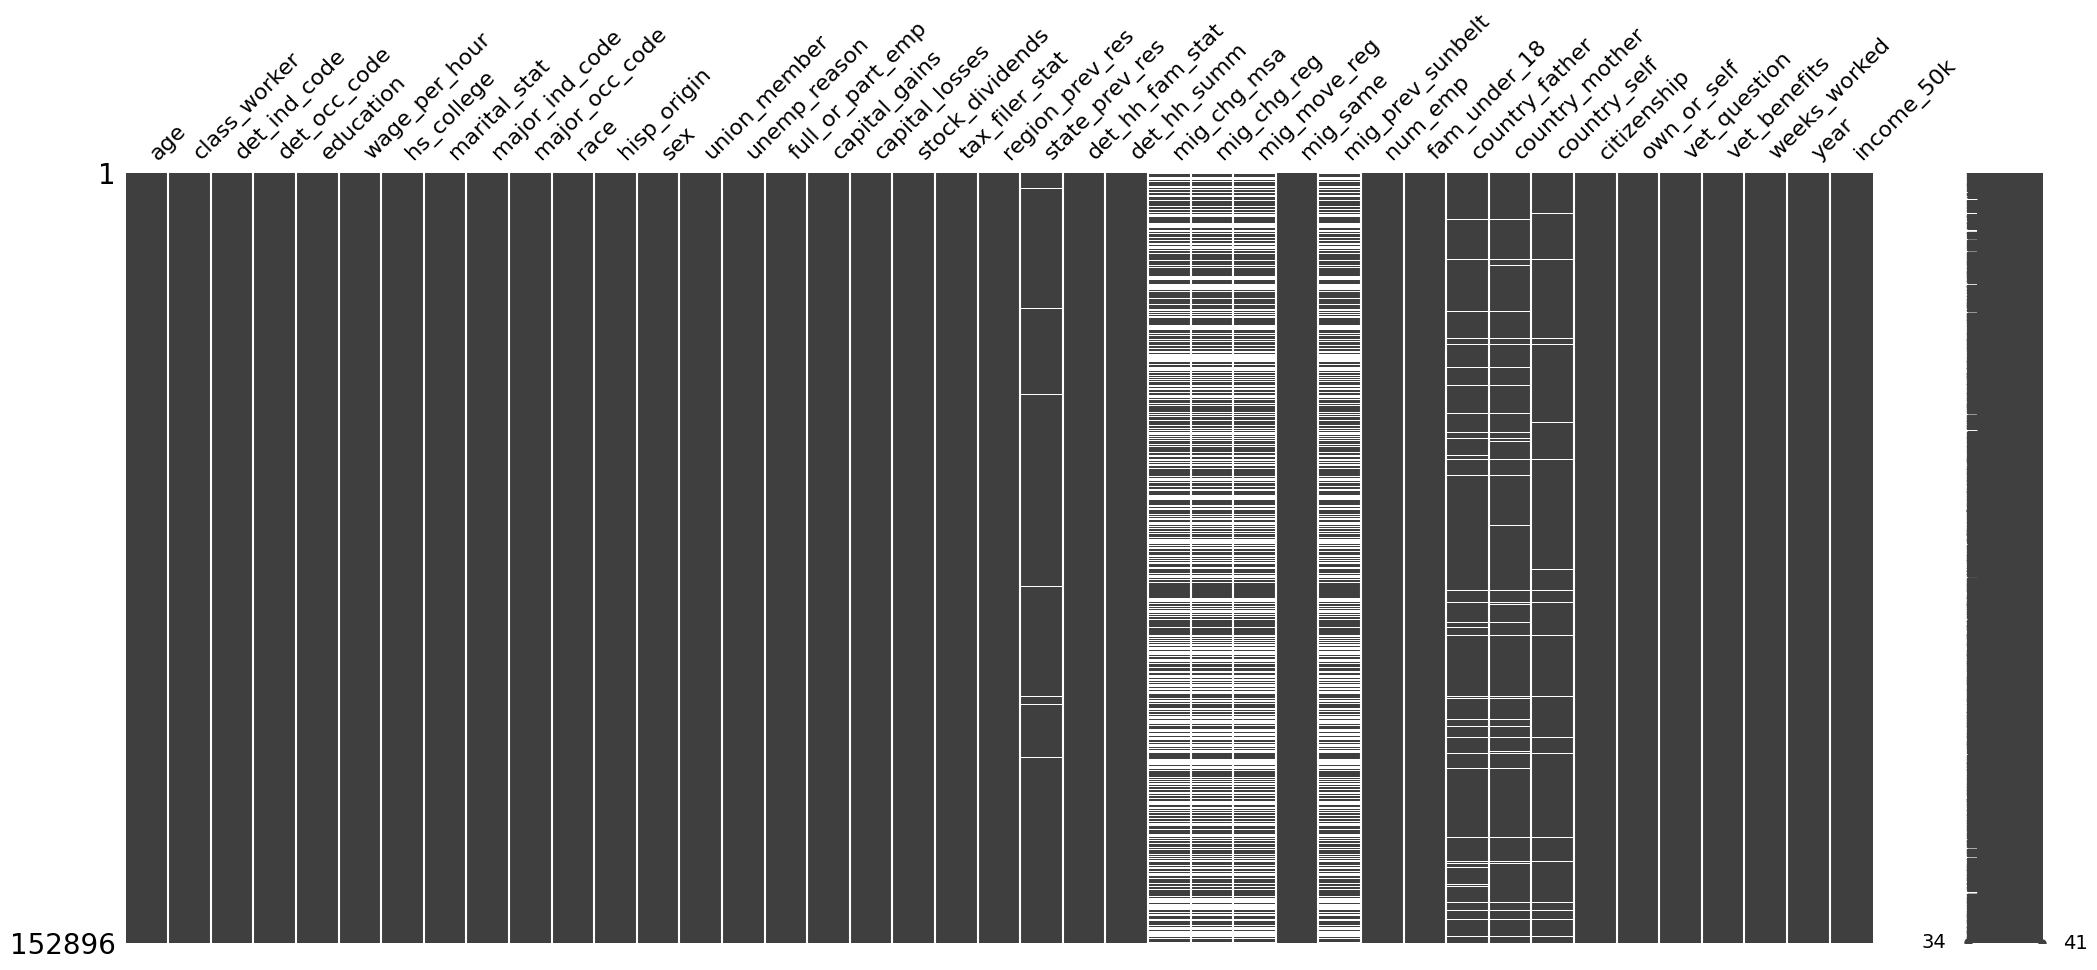

In [63]:
# plot the missing values
import missingno as msno
msno.matrix(df1)

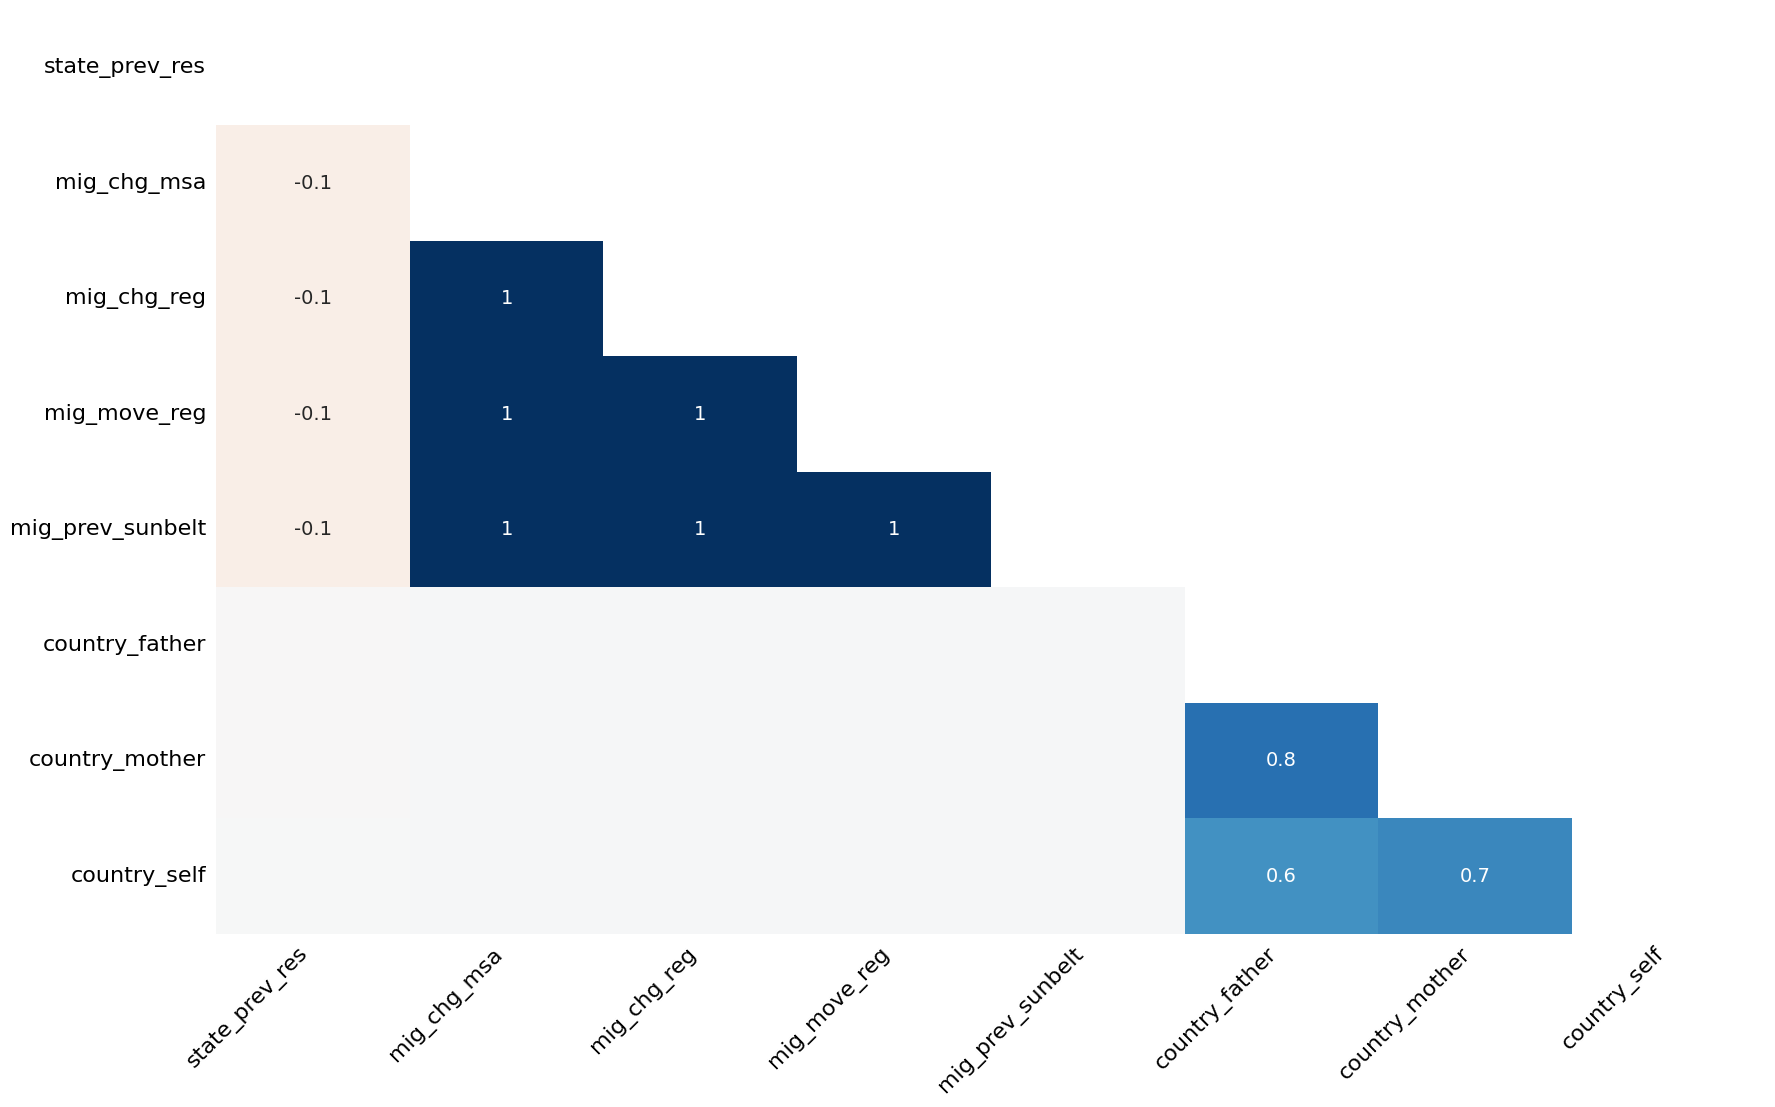

In [64]:
# plot the correlation between the missing values without the colorbar
msno.heatmap(df1, cbar=False)
# save the figure
plt.savefig('figures/missing_corr_heatmap.pdf', bbox_inches='tight')
plt.show()

We can see that the categories "mig_chg_msa", "mig_chg_reg", and "mig_move_reg" have a correlation of 1 with the target variable.

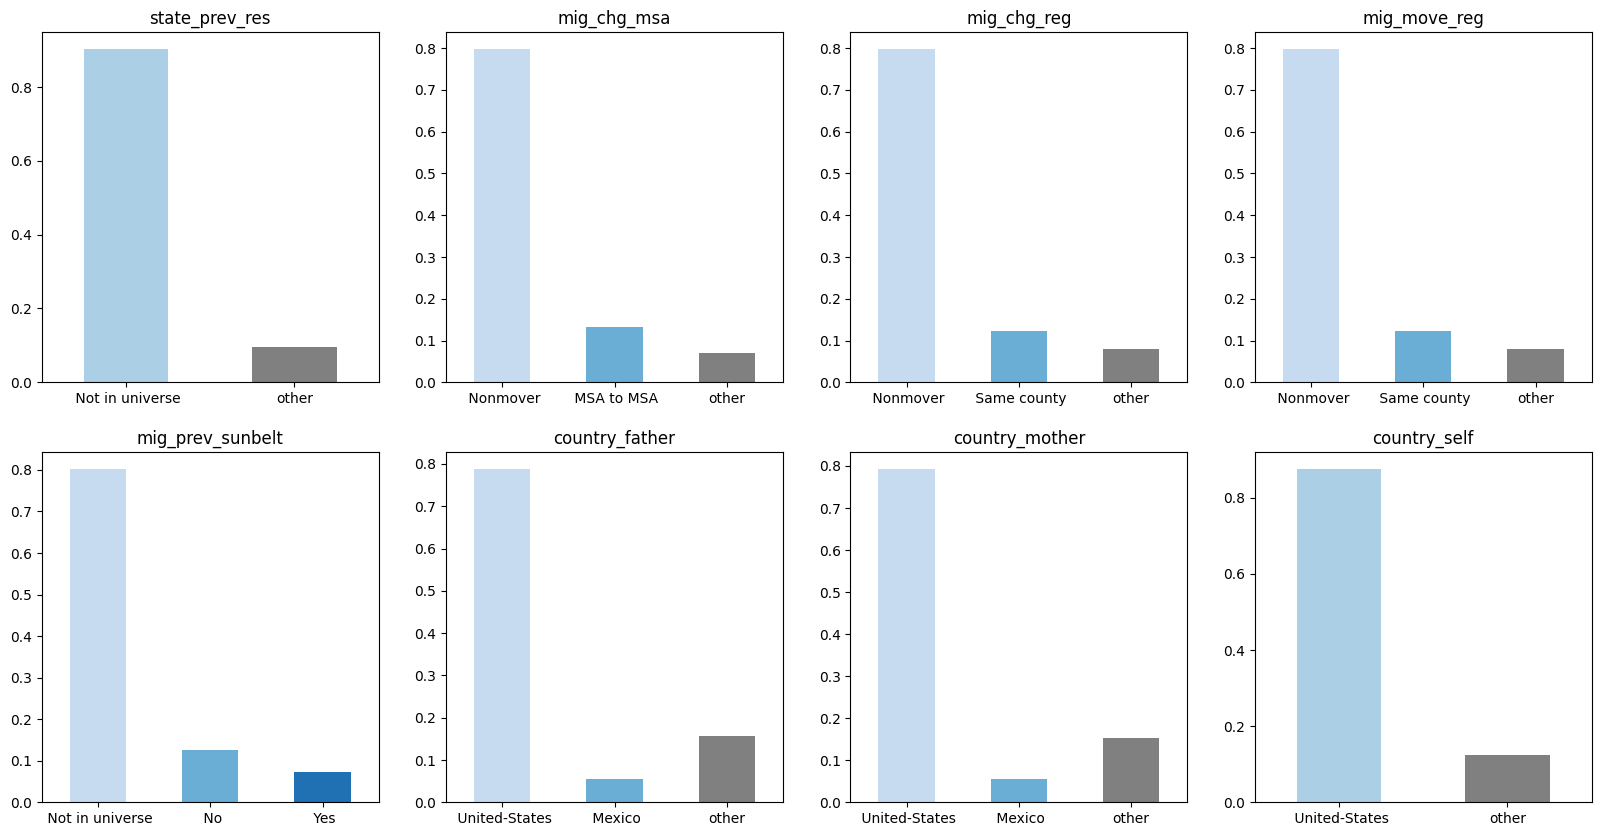

In [65]:
cols_with_missing = df1.columns[df1.isnull().any()]
barplots(df1, cols_with_missing, grid=(2,4), figsize=(20, 10))

### Treating missing values

In [66]:
print("Percentage of missing values per column:")
print(df1.isnull().sum()[df1.isnull().sum() > 0] / df1.shape[0])

Percentage of missing values per column:
state_prev_res      0.004565
mig_chg_msa         0.490163
mig_chg_reg         0.490163
mig_move_reg        0.490163
mig_prev_sunbelt    0.490163
country_father      0.041747
country_mother      0.038000
country_self        0.021727
dtype: float64


Missing values per year:

In [67]:
print("Percentage of missing values for the year 1994")
print(df1[df1['year'] == 94].isnull().sum()[df1[df1['year'] == 94].isnull().sum() > 0] / df1[df1['year'] == 94].shape[0])
print("Percentage of missing values for the year 1995")
print(df1[df1['year'] == 95].isnull().sum()[df1[df1['year'] == 95].isnull().sum() > 0] / df1[df1['year'] == 95].shape[0])

Percentage of missing values for the year 1994
state_prev_res    0.008954
country_father    0.040050
country_mother    0.036420
country_self      0.020320
dtype: float64
Percentage of missing values for the year 1995
mig_chg_msa         1.000000
mig_chg_reg         1.000000
mig_move_reg        1.000000
mig_prev_sunbelt    1.000000
country_father      0.043512
country_mother      0.039643
country_self        0.023191
dtype: float64


In [68]:
# we drop the columns with more than 40% of missing values
print(f"dropping columns: {cols_with_missing[df1[cols_with_missing].isnull().mean() > 0.4]}")
df1 = df1.drop(cols_with_missing[df1[cols_with_missing].isnull().mean() > 0.4], axis=1)
print(df1.isnull().sum()[df1.isnull().sum() > 0] / df1.shape[0])
cols_with_missing = df1.columns[df1.isnull().any()]

dropping columns: Index(['mig_chg_msa', 'mig_chg_reg', 'mig_move_reg', 'mig_prev_sunbelt'], dtype='object')
state_prev_res    0.004565
country_father    0.041747
country_mother    0.038000
country_self      0.021727
dtype: float64


<Axes: >

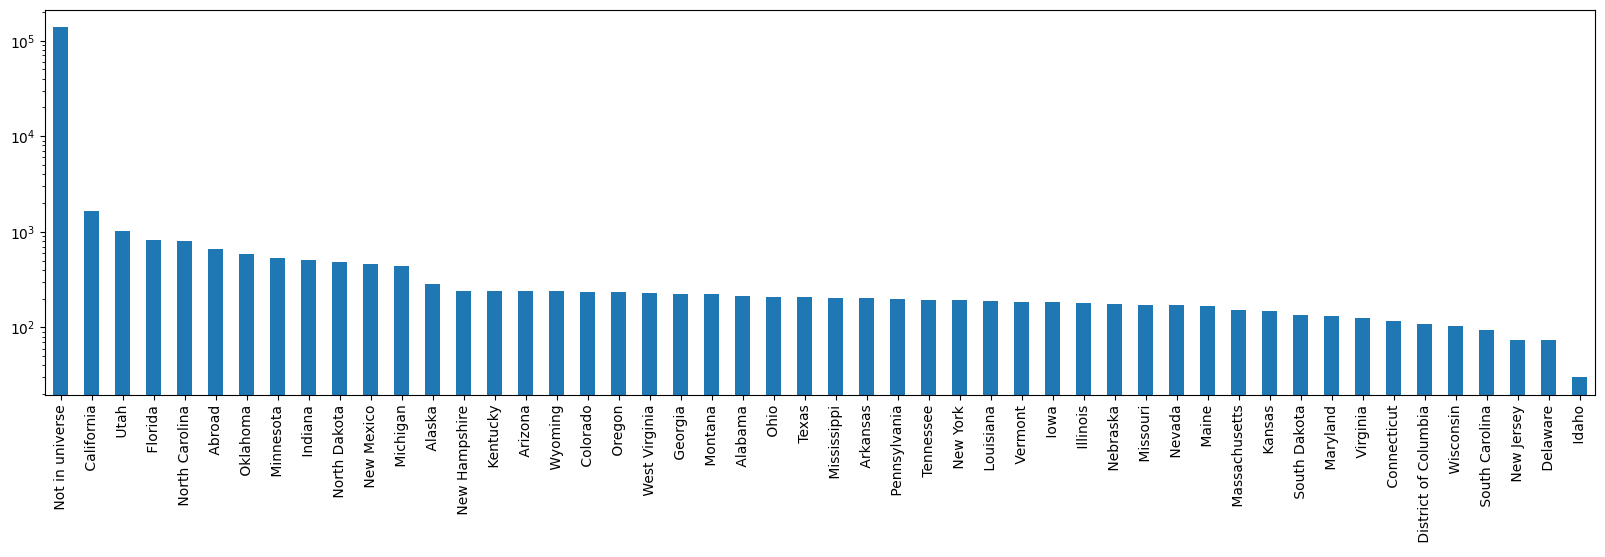

In [69]:
df1['state_prev_res'].value_counts().plot(kind='bar', logy=True, figsize=(20, 5))

since the columns state_prev_res, country_father, country_mother, and country_self have less than 5% of missing values, we can imputate them with the most frequent value.

In [70]:
# we fill the missing values with the most frequent value
cols_with_missing = df1.columns[df1.isnull().any()]
print(cols_with_missing)
for col in cols_with_missing:
    df1[col] = df1[col].fillna(df1[col].value_counts().index[0])  
print(f"Missing values: {sum(df1.isnull().sum())}")

Index(['state_prev_res', 'country_father', 'country_mother', 'country_self'], dtype='object')
Missing values: 0


### Converting numerical variables to categorical

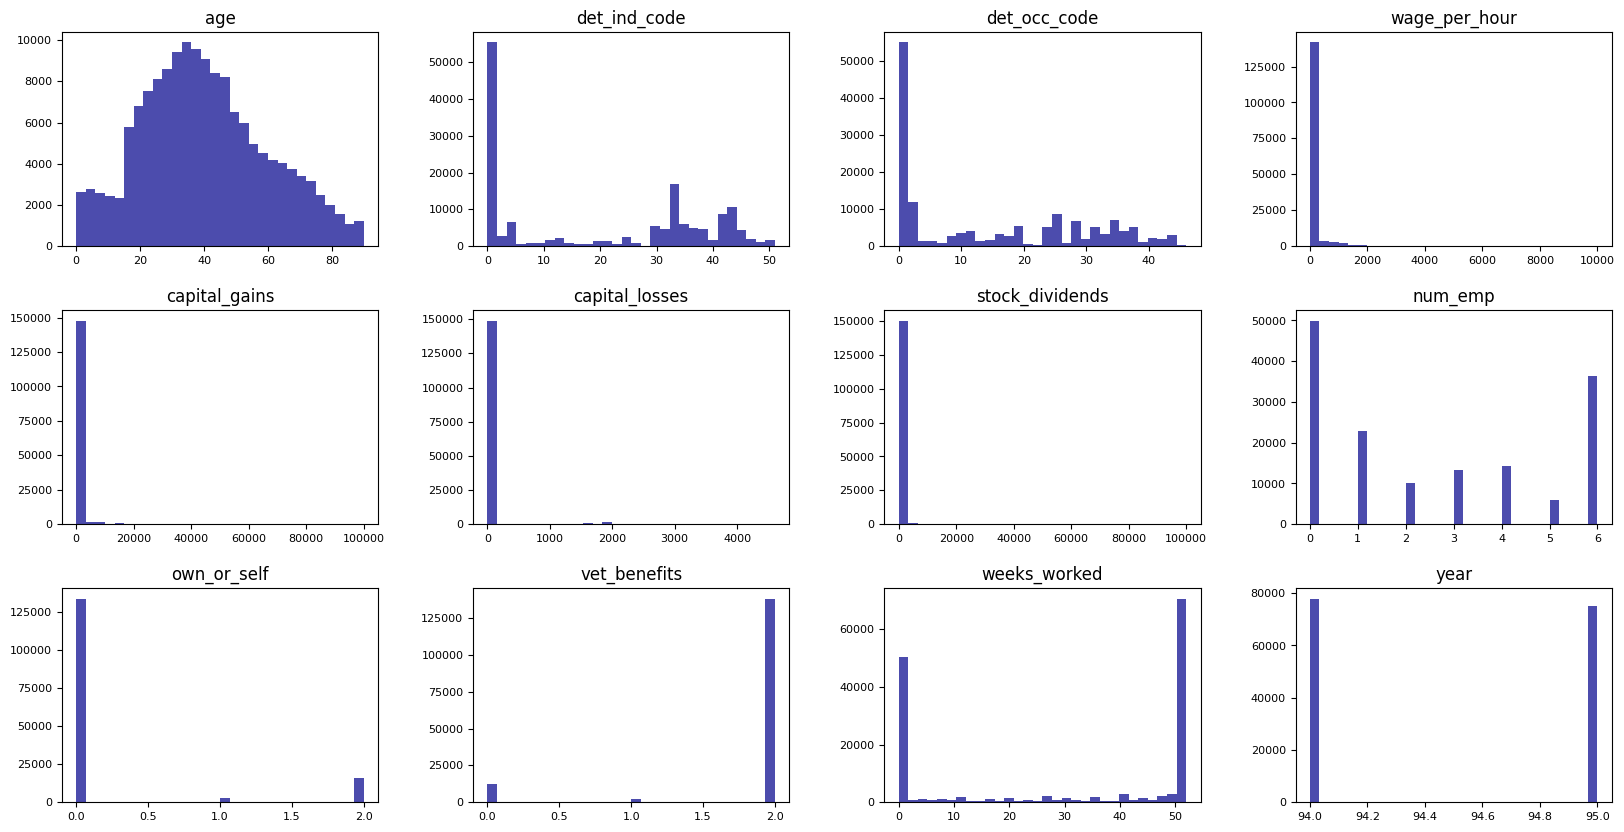

In [74]:
df1.hist(figsize=(20,10), bins=30, xlabelsize=8, ylabelsize=8, layout=(3,4), color='darkblue', alpha=0.7, grid=False)
plt.show()

In [75]:
# categorical columns hidden as numerical
for col in ['det_ind_code', 'det_occ_code', 'own_or_self', 'vet_benefits', 'year']:
    df1[col] = df1[col].astype('category')

In [76]:
age_bins = [0, 18, 25, 35, 45, 55, 65, 75, 85, 95, 105]
df1['age'] = pd.cut(df1['age'], bins=age_bins, labels=age_bins[:-1], include_lowest=True)

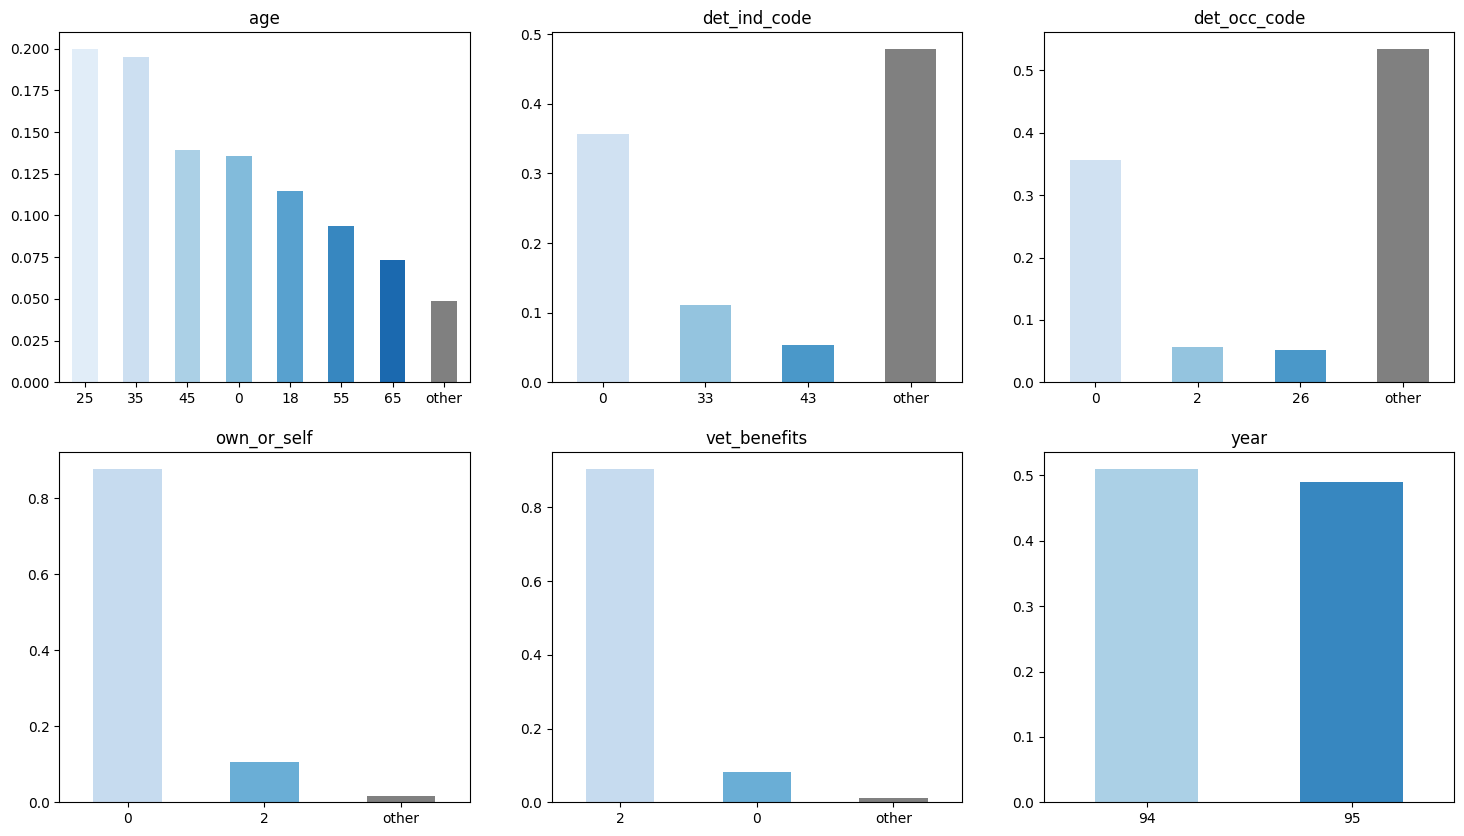

In [46]:
barplots(df1, ['age', 'det_ind_code', 'det_occ_code', 'own_or_self', 'vet_benefits', 'year'],
            grid=(2,3), figsize=(18, 10), save='figures/num_conv_barplots.pdf')

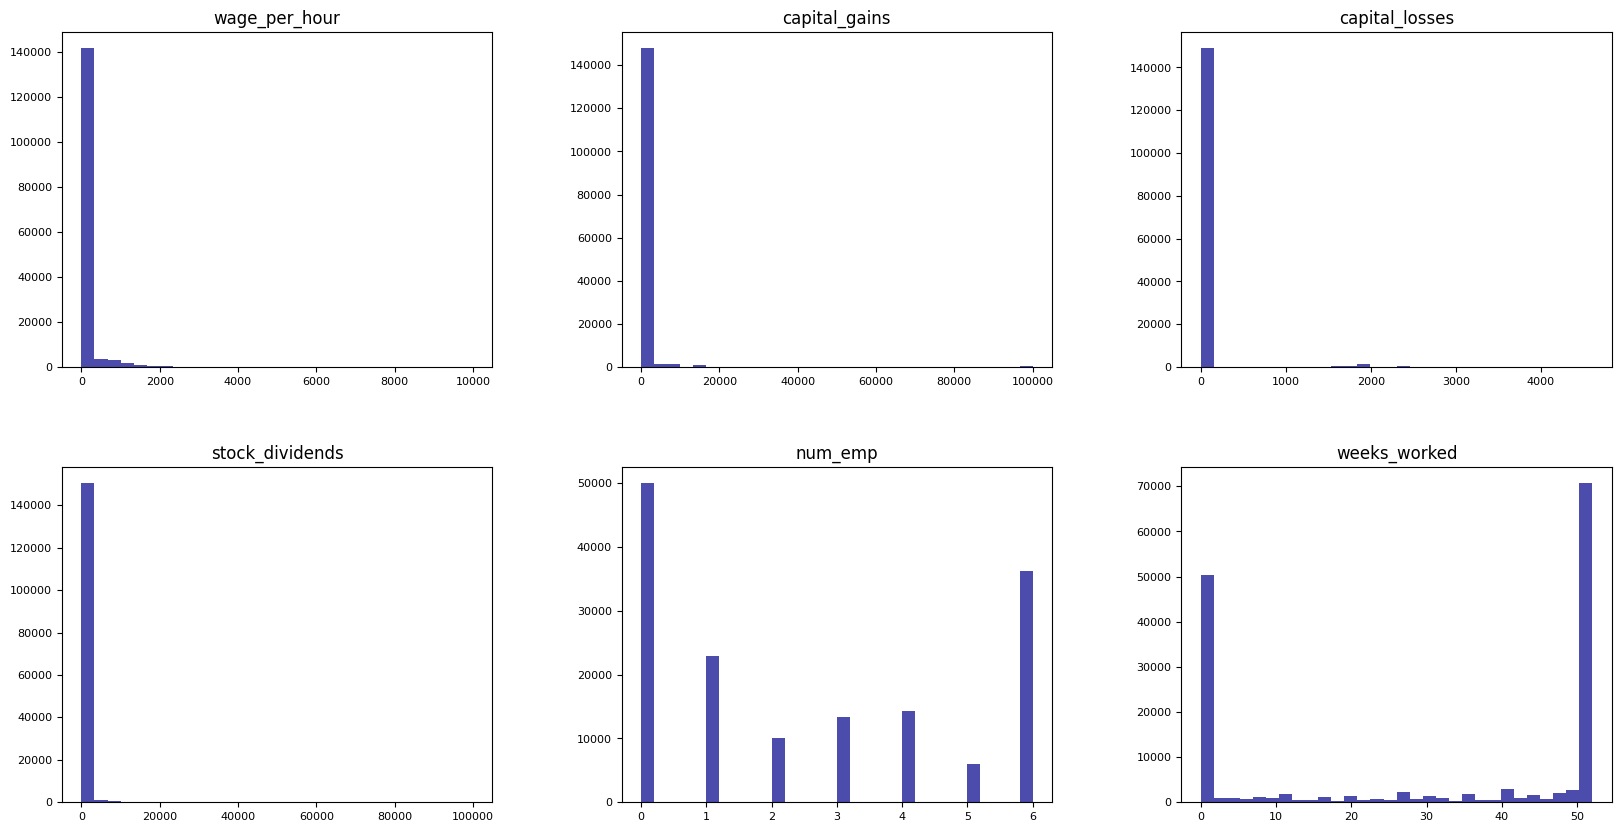

In [82]:
df1.hist(figsize=(20,10), bins=30, xlabelsize=8, ylabelsize=8, layout=(2, 3), color='darkblue', alpha=0.7, grid=False)
plt.savefig('figures/num_conv_histograms.pdf', bbox_inches='tight')
plt.show()

We can merge capital_gains and capital_losses into a new variable called "capital_balance" which is the difference between the two.

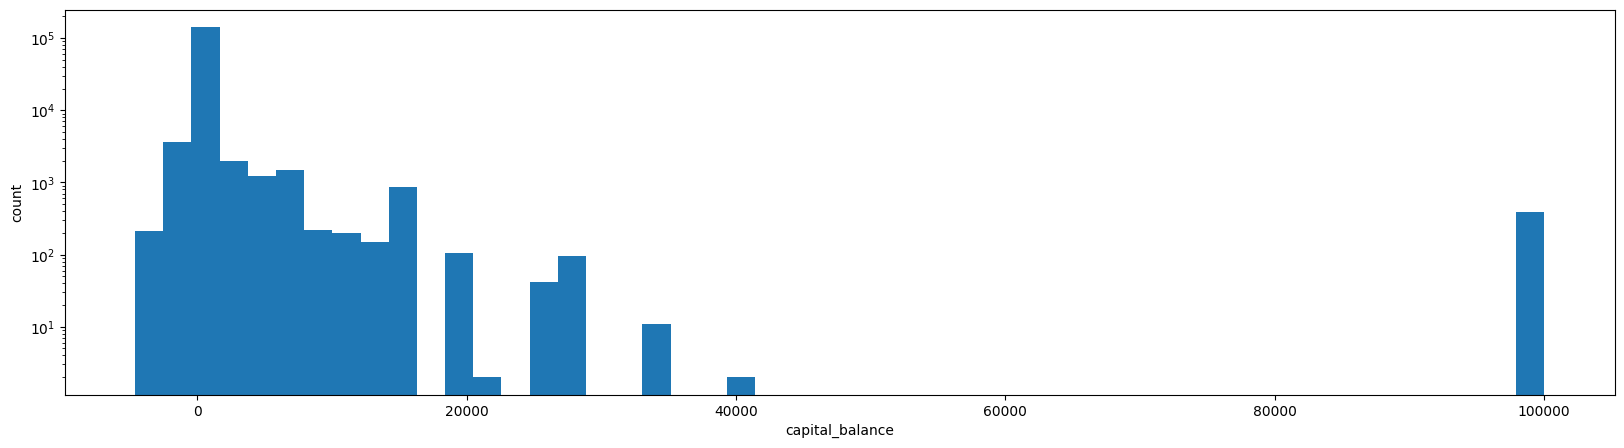

In [36]:
df1['capital_balance'] = df1['capital_gains'] - df1['capital_losses']
df1 = df1.drop(['capital_gains', 'capital_losses'], axis=1)
# plot capital_balance with log scale
df1['capital_balance'].plot(kind='hist', logy=True, bins=50, figsize=(20, 5))
plt.xlabel('capital_balance')
plt.ylabel('count')
plt.show()

We scale the remaining numerical variables.

array([[<Axes: title={'center': 'wage_per_hour'}>,
        <Axes: title={'center': 'stock_dividends'}>],
       [<Axes: title={'center': 'num_emp'}>,
        <Axes: title={'center': 'weeks_worked'}>],
       [<Axes: title={'center': 'capital_balance'}>, <Axes: >]],
      dtype=object)

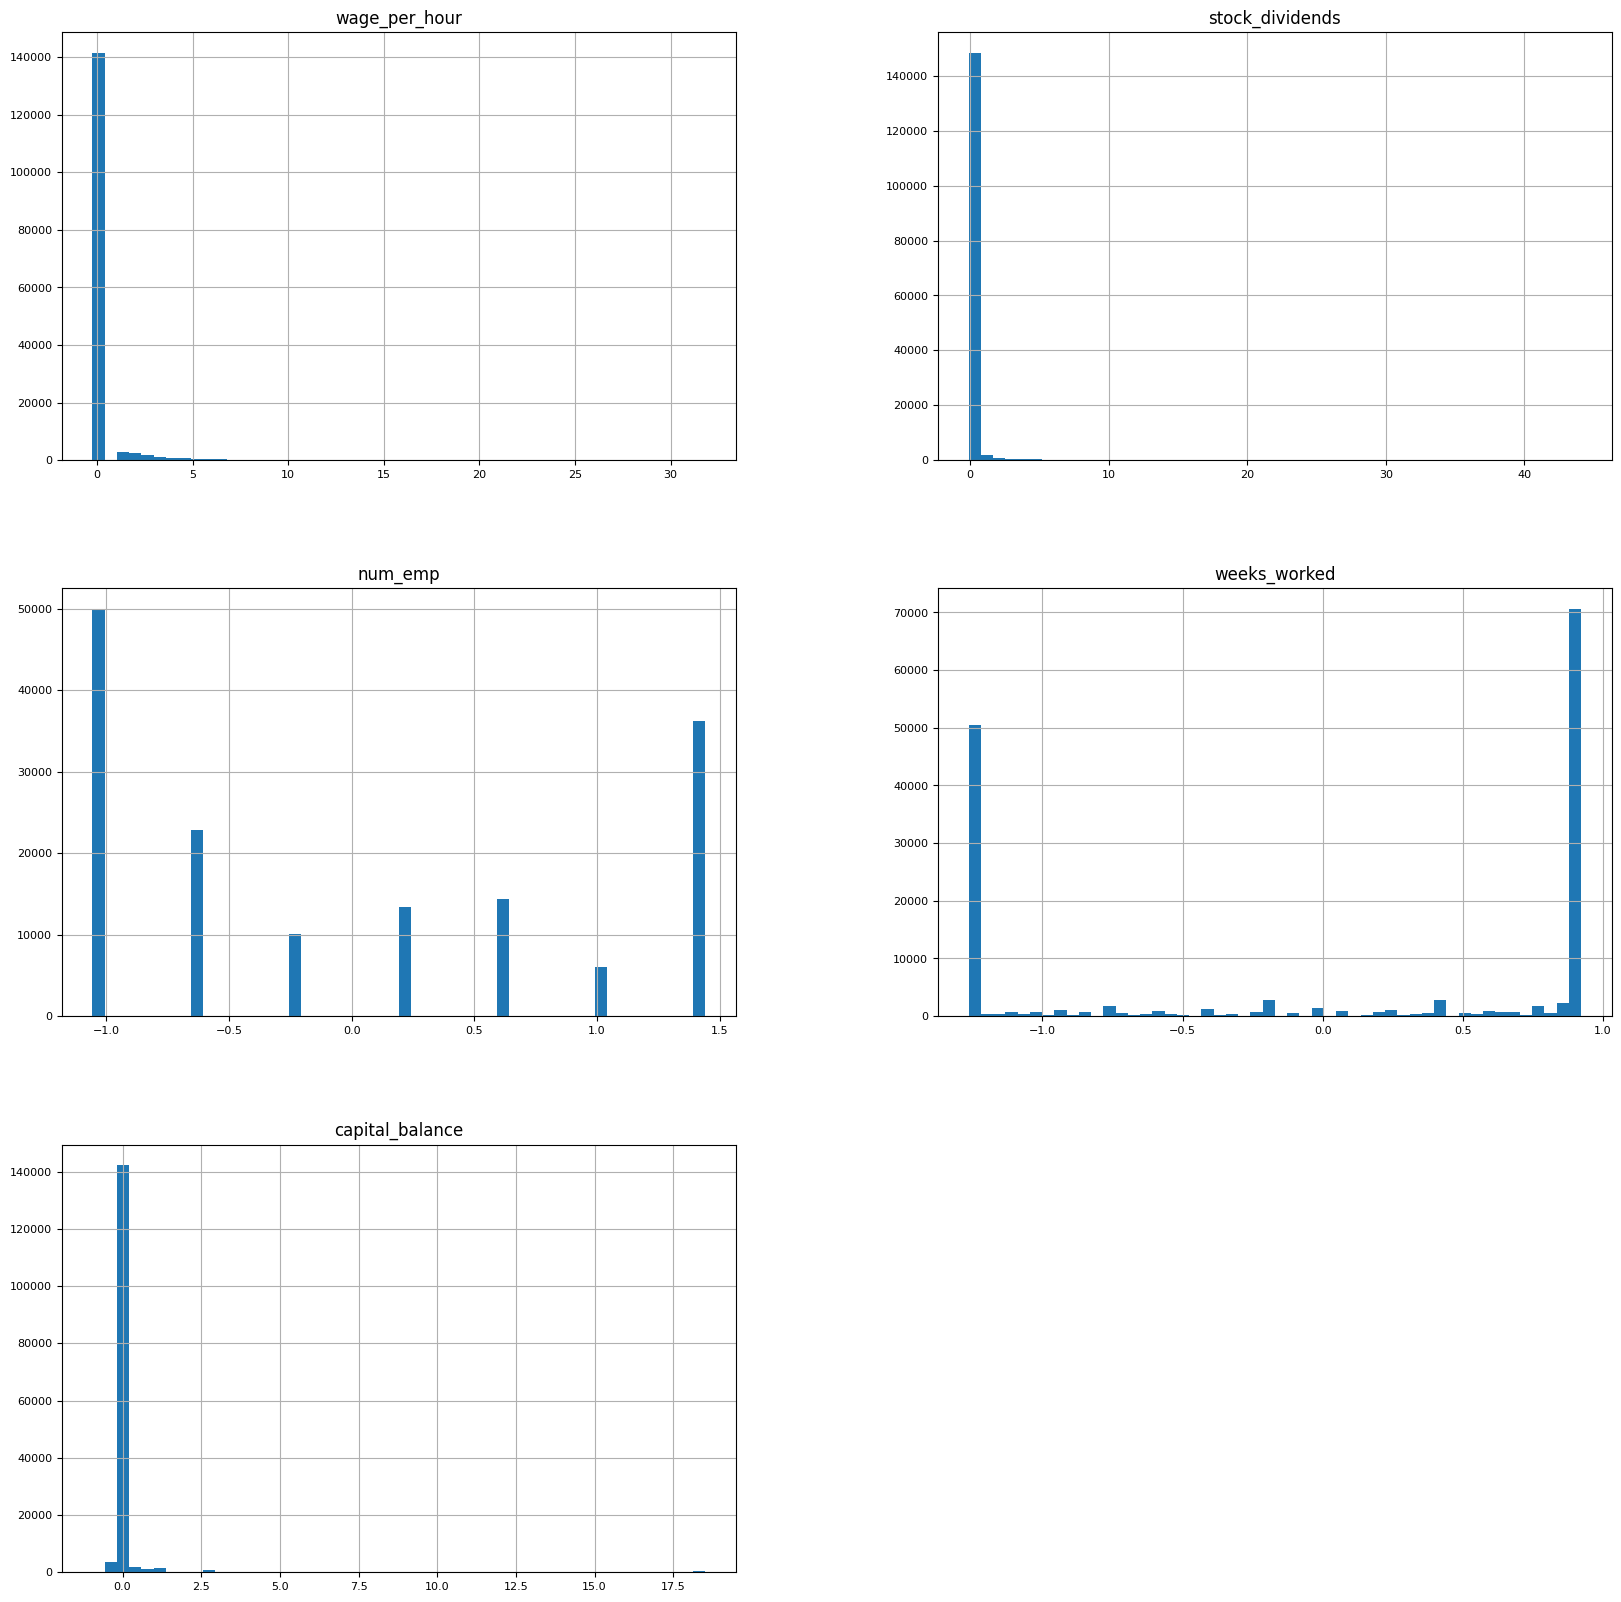

In [37]:
# scale the numerical features
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

num_cols = df1.select_dtypes(include=['int64', 'float64']).columns
df1[num_cols] = scaler.fit_transform(df1[num_cols])

df1.hist(figsize=(20,20), bins=50, xlabelsize=8, ylabelsize=8, grid=(2,3))

In [38]:
# convert all object columns type to category type
for col in df1.select_dtypes(include=['object']).columns:
    df1[col] = df1[col].astype('category')